# AdaBoost Classifier Implimentation From Scratch

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

### create a Dataset

In [412]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=20,    # Number of samples
    n_features=2,    # Total number of features
    n_informative=1, # Number of informative features
    n_redundant=0,   # Number of redundant features
    n_classes=2,     # Number of target classes
    n_clusters_per_class=1,
)

In [413]:
y.shape

(20,)

In [414]:
df = pd.DataFrame(X)

In [415]:
df.head()

,0,1
0,1.677525,0.872237
1,-0.933648,-0.246199
2,-0.493365,0.760188
3,-1.652104,-1.163156
4,1.828228,-1.151223


In [416]:
df['label'] = y

In [417]:
df['label']

0     1
1     0
2     1
3     1
4     0
5     0
6     0
7     1
8     1
9     0
10    0
11    0
12    0
13    0
14    1
15    1
16    1
17    1
18    1
19    1
Name: label, dtype: int32

In [418]:
df.head()

,0,1,label
0,1.677525,0.872237,1
1,-0.933648,-0.246199,0
2,-0.493365,0.760188,1
3,-1.652104,-1.163156,1
4,1.828228,-1.151223,0


<Axes: xlabel='0', ylabel='1'>

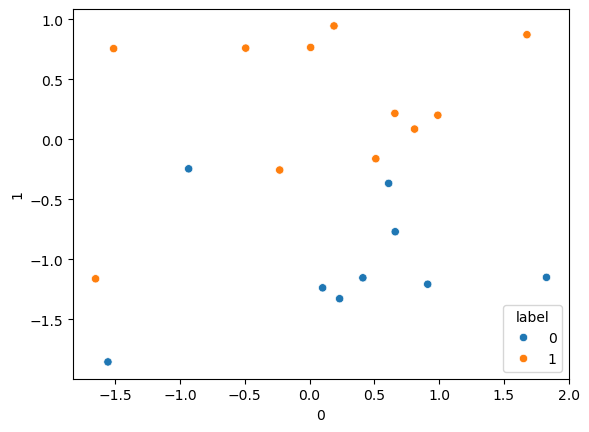

In [419]:
sns.scatterplot(x=df[0], y=df[1], hue=df['label'])

### Class of AdaBoost

In [362]:
class AdaBoostClassifier:
    
    model_weight = 0
    indices = []
    
    def __init__(self, dt, df):
        self.dt = dt
        self.df_copy = df.copy()
        self.df = df.copy()
        self.X = np.array(self.df.iloc[:, :-1])
        self.y = np.array(self.df.iloc[:,-1])

    def assign_equal_weights(self):
        self.df['weights'] = 1/self.df.shape[0]

    def train_model(self):
        self.dt.fit(self.X, self.y)

    def prediction(self):
        self.df['y_pred'] = self.dt.predict(self.X)
        return self.df

    def alpha(self):
        t_error = 0
        for _, row in self.df.iterrows():
            if row['label'] != row['y_pred']:
                t_error += row['weights']

        # Avoid division by zero
        if t_error == 0:
            t_error = 1e-10

        self.model_weight = 0.5 * np.log((1 - t_error) / t_error)
        return self.model_weight
    
    def upsampling(self):
        self.df['weights'] = self.df.apply(
            lambda row: row['weights'] * np.exp(-self.model_weight) if row['label'] == row['y_pred'] 
            else row['weights'] * np.exp(self.model_weight), axis=1
        )

    def normalize(self):
        # Normalize weights so they sum up to 1
        total_weight = self.df['weights'].sum()
        self.df['weights'] = self.df['weights'] / total_weight

    def upper_lower_range(self):
        self.df['upper_range'] = np.cumsum(self.df['weights'])
        self.df['lower_range'] = self.df['upper_range'] - self.df['weights']
        
    def generate_dataset(self):
        # clear indices before starting
        self.indices = []
        
        size = self.df.shape[0]
        
        for _ in range(size):
            num = np.random.random()
            for index, row in self.df.iterrows():
                if num > row['lower_range'] and num < row['upper_range']:
                    self.indices.append(index)
                    
        return self.indices
    
    def create_dataframe(self):
        # Create a new DataFrame from selected indices, dropping the unwanted columns inplace
        new_df = self.df.iloc[self.indices]
        new_df.drop(columns=['lower_range', 'upper_range', 'weights', 'y_pred'], inplace=True)
        
        return new_df
    
                

In [397]:
class AdaBoostProcess:

    def __init__(self, base_model, data, n_estimators):
        self.base_model = base_model
        self.data = data
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self):
        current_data = self.data.copy()

        for i in range(self.n_estimators):
            print(f"Training model {i + 1}/{self.n_estimators}...")

            # Step 1: Initialize AdaBoostClassifier with the current data
            ada = AdaBoostClassifier(self.base_model, current_data)

            # Step 2: Assign equal weights
            ada.assign_equal_weights()

            # Step 3: Train the model
            ada.train_model()

            # Step 4: Make predictions
            ada.prediction()

            # Step 5: Calculate model weight
            model_weight = ada.alpha()
            self.alphas.append(model_weight)

            # Step 6: Upsample and normalize weights
            ada.upsampling()
            ada.normalize()

            # Step 7: Calculate upper and lower ranges for sampling
            ada.upper_lower_range()

            # Step 8: Generate new dataset
            indices = ada.generate_dataset()
            current_data = ada.create_dataframe()  # Update dataset for the next iteration

            # Step 9: Store the trained model
            self.models.append(ada.dt)

        print("Training complete!")
        return self.models, self.alphas

    def predict(self, X):

        predicts = np.zeros(X.shape[0])

        for model, alpha in zip(self.models, self.alphas):

            pred = model.predict(X)
            pred = np.where(pred == 0, -1, 1)

            predicts += alpha * pred

        final_prediction = np.where(predicts > 0, 1, 0)

        return final_prediction 

In [420]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=1)

In [431]:
ada = AdaBoostProcess(dt, df, 5)
ada.fit()

Training model 1/5...
Training model 2/5...
Training model 3/5...
Training model 4/5...
Training model 5/5...
Training complete!


C:\Users\ask50\AppData\Local\Temp\ipykernel_21220\2605241108.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(columns=['lower_range', 'upper_range', 'weights', 'y_pred'], inplace=True)
C:\Users\ask50\AppData\Local\Temp\ipykernel_21220\2605241108.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(columns=['lower_range', 'upper_range', 'weights', 'y_pred'], inplace=True)
C:\Users\ask50\AppData\Local\Temp\ipykernel_21220\2605241108.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

([DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1)],
 [1.0986122886681098,
  0.8673005276940532,
  11.512925464920228,
  11.512925464920228,
  11.512925464920228])

In [432]:
X.shape

(20, 2)

In [433]:
y_pred = ada.predict(X)

In [439]:
print(y, y_pred)

[1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [434]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, y)

0.55

<Axes: >

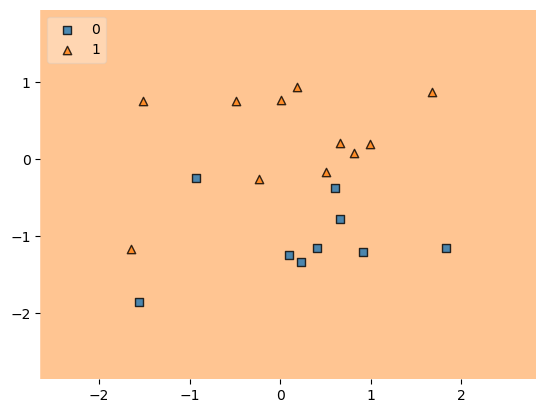

In [438]:
plot_decision_regions(X, y, clf=ada.models[2], legend=2)
